In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load raw data
# Takes about 1 minute to load
data = pd.read_excel('Spectronaut\KR_Covid_DIA_Pt_gene_Serum30_Report_Protein Quant (Pivot).xlsx')

<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:3: SyntaxWarning: invalid escape sequence '\K'
C:\Users\treharne\AppData\Local\Temp\ipykernel_16388\2048493575.py:3: SyntaxWarning: invalid escape sequence '\K'
  data = pd.read_excel('Spectronaut\KR_Covid_DIA_Pt_gene_Serum30_Report_Protein Quant (Pivot).xlsx')


In [3]:
# Make first column index
data.set_index('PG.ProteinGroups', inplace=True)

In [4]:
# Transpose
data = data.T

In [5]:
# Load mapping file
mapping = pd.read_csv('Spectronaut\Meta_Plates.csv')

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\treharne\AppData\Local\Temp\ipykernel_16388\3225066758.py:2: SyntaxWarning: invalid escape sequence '\M'
  mapping = pd.read_csv('Spectronaut\Meta_Plates.csv')


In [6]:
# Ensure columns "Collection" and "Sample" exist in the DataFrame
data['Collection'] = None
data['Sample'] = None

# Iterate through the mapping file.
# Find row in data where index contains mapping["File"]
# Add Collection and Sample values from mapping to data
for index, row in mapping.iterrows():
    file_str = str(row["File"])  # Ensure the value is a string
    data.loc[data.index.str.contains(file_str), "Collection"] = row["Collection"]
    data.loc[data.index.str.contains(file_str), "Sample"] = row["Sample"]


In [7]:
# set Sample to index (overwriting the previous index)
data.set_index('Sample', inplace=True)  

In [8]:
len(data)

1033

In [9]:
# Create a dataframe containing Surrey data only
surrey_data = data[data['Collection'] == 'Surrey']

In [10]:
# remove Collection column as it is no longer needed
surrey_data.drop(columns='Collection', inplace=True)

C:\Users\treharne\AppData\Local\Temp\ipykernel_16388\2042261723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surrey_data.drop(columns='Collection', inplace=True)


In [11]:
# Drop all columns that have no values
surrey_data = surrey_data.dropna(axis=1, how='all')

In [12]:
# normalise data
# this is important
scaler = MinMaxScaler()
norm_data = pd.DataFrame(scaler.fit_transform(surrey_data), columns=surrey_data.columns, index=surrey_data.index)

In [13]:
norm_data.head()

PG.ProteinGroups,A0A075B6I0,A0A075B6I9,A0A075B6K5,A0A075B6R2,A0A075B6S6,A0A087WSY4,A0A087WSY6,A0A087WSZ0,A0A0A0MS14,A0A0A0MS15,...,Q9Y4F1;Q9Y4F1-2,Q9Y4L1,Q9Y5C1,Q9Y5Y7,Q9Y617,Q9Y624,Q9Y646,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-3;Q9Y6N7-4;Q9Y6N7-5;Q9Y6N7-6,Q9Y6R7,Q9Y6Z7
Sample,,,,,,,,,,,,,,,,,,,,,
221-0_110520,0.051972,0.326761,NaN,NaN,NaN,NaN,0.173907,NaN,NaN,0.183510,...,NaN,0.273308,0.138065,0.047446,0.027221,NaN,0.026474,NaN,0.177498,0.369005
221-2_130520,0.043139,0.071546,NaN,NaN,NaN,NaN,0.092960,NaN,NaN,0.096378,...,NaN,0.207914,0.083847,0.035717,NaN,NaN,0.024688,NaN,0.153731,0.410676
222-0_120520,0.103401,NaN,NaN,0.709437,NaN,0.382688,0.388500,NaN,0.0,0.382634,...,NaN,0.243585,0.128326,0.093836,0.025723,NaN,0.172540,0.091727,0.073414,0.505914
222-2_140520,0.171297,NaN,NaN,0.603770,NaN,0.235045,0.279943,NaN,NaN,0.250364,...,NaN,0.210605,0.112459,0.107324,NaN,NaN,0.146429,NaN,0.054899,0.342057
223_120520,NaN,NaN,NaN,0.335381,NaN,0.230414,0.635657,NaN,NaN,0.284596,...,NaN,NaN,NaN,0.071303,0.000000,NaN,0.084471,NaN,0.197408,0.276569


In [14]:
# Impute!

# Using nearest neighbours
imputer = KNN()
imputed_data = imputer.fit_transform(norm_data)

# create a new dataframe with the imputed data
imputed_data = pd.DataFrame(imputed_data)

# make new_frame column names the same as data
imputed_data.columns = norm_data.columns

#make new_frame index the same as data
imputed_data.index = norm_data.index

Imputing row 1/218 with 447 missing, elapsed time: 0.526
Imputing row 101/218 with 491 missing, elapsed time: 1.181
Imputing row 201/218 with 327 missing, elapsed time: 1.724


In [15]:
# Inspect the imputed data
imputed_data.head()

PG.ProteinGroups,A0A075B6I0,A0A075B6I9,A0A075B6K5,A0A075B6R2,A0A075B6S6,A0A087WSY4,A0A087WSY6,A0A087WSZ0,A0A0A0MS14,A0A0A0MS15,...,Q9Y4F1;Q9Y4F1-2,Q9Y4L1,Q9Y5C1,Q9Y5Y7,Q9Y617,Q9Y624,Q9Y646,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-3;Q9Y6N7-4;Q9Y6N7-5;Q9Y6N7-6,Q9Y6R7,Q9Y6Z7
Sample,,,,,,,,,,,,,,,,,,,,,
221-0_110520,0.051972,0.326761,0.154343,0.188580,0.065847,0.115567,0.173907,0.380979,0.166803,0.183510,...,0.433240,0.273308,0.138065,0.047446,0.027221,0.079813,0.026474,0.229009,0.177498,0.369005
221-2_130520,0.043139,0.071546,0.142512,0.166629,0.066648,0.067785,0.092960,0.376078,0.178522,0.096378,...,0.302861,0.207914,0.083847,0.035717,0.040158,0.079631,0.024688,0.090131,0.153731,0.410676
222-0_120520,0.103401,0.248759,0.167082,0.709437,0.104271,0.382688,0.388500,0.374143,0.000000,0.382634,...,0.528215,0.243585,0.128326,0.093836,0.025723,0.115326,0.172540,0.091727,0.073414,0.505914
222-2_140520,0.171297,0.236590,0.162740,0.603770,0.106877,0.235045,0.279943,0.357550,0.122969,0.250364,...,0.400746,0.210605,0.112459,0.107324,0.038529,0.053349,0.146429,0.259753,0.054899,0.342057
223_120520,0.093115,0.248437,0.157940,0.335381,0.095018,0.230414,0.635657,0.414648,0.149858,0.284596,...,0.526410,0.254817,0.124830,0.071303,0.000000,0.078056,0.084471,0.235324,0.197408,0.276569


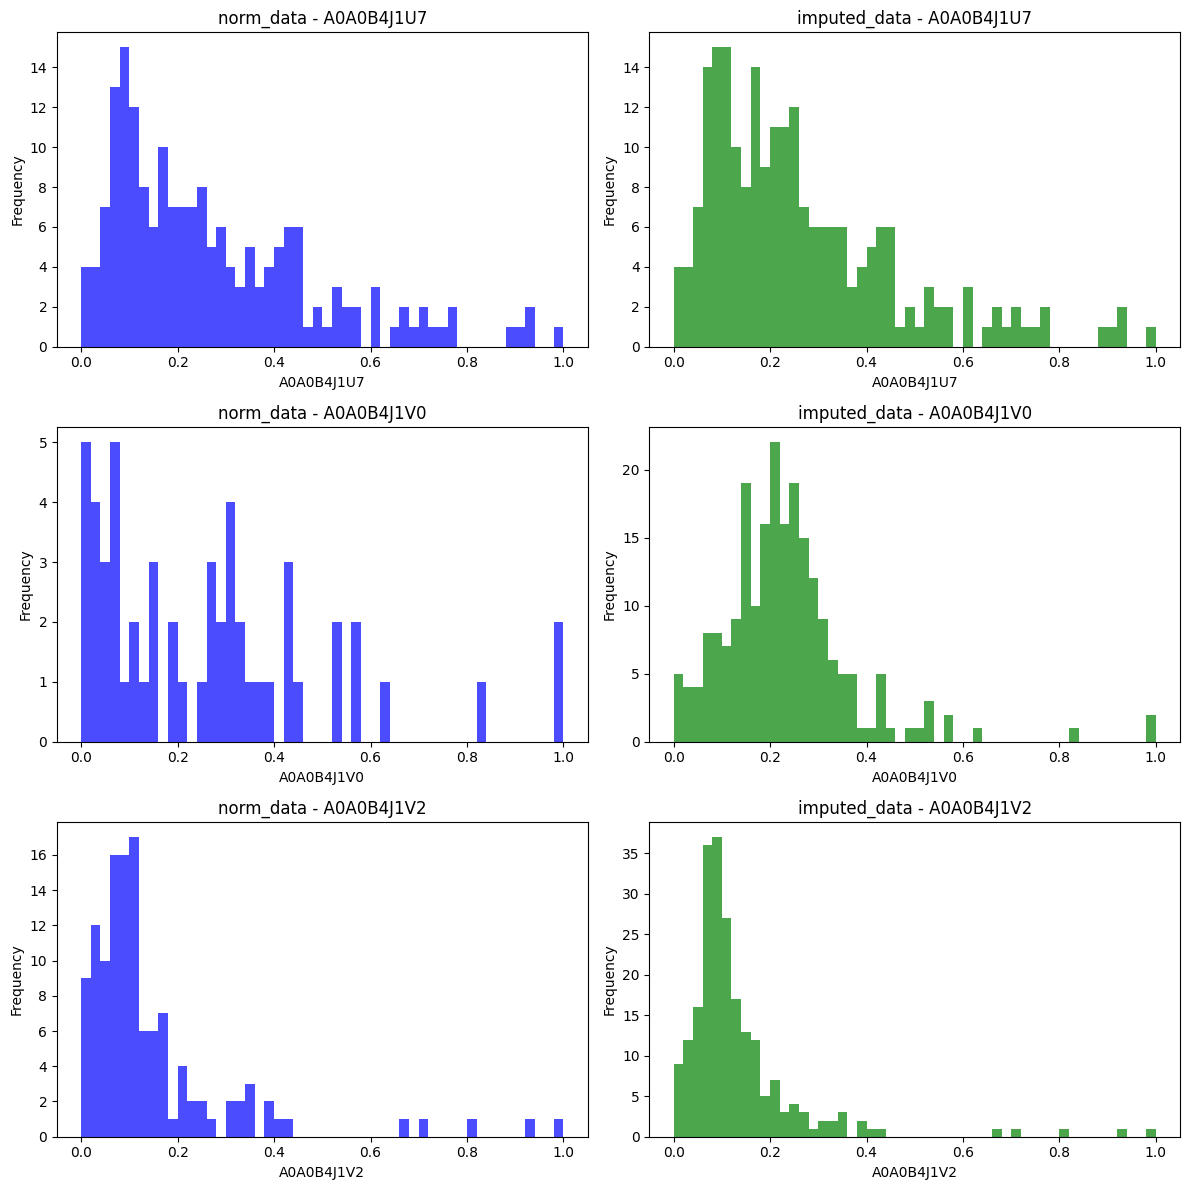

In [16]:
# Check a couple of distributions

fig, axes = plt.subplots(3, 2, figsize=(12, 12))


for i, col in enumerate(norm_data.columns[10:13]):
    axes[i, 0].hist(norm_data[col], bins=50, alpha=0.7, color='blue', label='norm_data')
    axes[i, 0].set_title(f'norm_data - {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    
    axes[i, 1].hist(imputed_data[col], bins=50, alpha=0.7, color='green', label='imputed_data')
    axes[i, 1].set_title(f'imputed_data - {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

For proteins where there is a high proportion of missingness the imputation is essentially completely made up.

In [20]:
# Combine norm_data and metadata

# Read metadata
metadata = pd.read_csv('Metadata\Surrey_Metadata_master_spreadsheet_130622_edit2.csv')

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\treharne\AppData\Local\Temp\ipykernel_16388\956648991.py:4: SyntaxWarning: invalid escape sequence '\S'
  metadata = pd.read_csv('Metadata\Surrey_Metadata_master_spreadsheet_130622_edit2.csv')


In [21]:
metadata.head()

,Sample,Chol,Age,Agreed to be contacted for future studies,Airway Disease,BMI,Bilateral CXR changes,CPAP,CRP,CXR comments,...,Serum 7,Serum 8,Serum 9,Smoking Status,Survived Admission,T2DM,Time between pos covid test and first sample,Weight (kg),Dates of repeat samples,Days_between
0,221-0_110520,N,29.0,�,0,NaN,Y,Y,146,NaN,...,Y,Y,Y,0.0,Y,N,8.0,NaN,11/05/2020,0
1,221-2_130520,N,29.0,�,0,NaN,Y,Y,146,NaN,...,Y,Y,Y,0.0,Y,N,8.0,NaN,13/05/20,2
2,222-0_120520,Y,67.0,�,0,24.7,Y,N,108,NaN,...,Y,Y,Y,1.0,Y,N,8.0,94.0,12/05/2020,0
3,222-2_140520,Y,67.0,�,0,24.7,Y,N,108,NaN,...,Y,Y,Y,1.0,Y,N,8.0,94.0,14/05/20,2
4,222-158_191020,Y,67.0,�,0,24.7,Y,N,108,NaN,...,Y,Y,Y,1.0,Y,N,8.0,94.0,19/10/20,158


In [22]:
# Set index as Sample ID
metadata.set_index('Sample', inplace=True)

In [23]:
# Merge with imputed_data on index
merged_data = pd.merge(imputed_data, metadata, left_index=True, right_index=True)

In [24]:
# Inspect
merged_data.head()

,A0A075B6I0,A0A075B6I9,A0A075B6K5,A0A075B6R2,A0A075B6S6,A0A087WSY4,A0A087WSY6,A0A087WSZ0,A0A0A0MS14,A0A0A0MS15,...,Serum 7,Serum 8,Serum 9,Smoking Status,Survived Admission,T2DM,Time between pos covid test and first sample,Weight (kg),Dates of repeat samples,Days_between
Sample,,,,,,,,,,,,,,,,,,,,,
221-0_110520,0.051972,0.326761,0.154343,0.188580,0.065847,0.115567,0.173907,0.380979,0.166803,0.183510,...,Y,Y,Y,0.0,Y,N,8.0,NaN,11/05/2020,0
221-2_130520,0.043139,0.071546,0.142512,0.166629,0.066648,0.067785,0.092960,0.376078,0.178522,0.096378,...,Y,Y,Y,0.0,Y,N,8.0,NaN,13/05/20,2
222-0_120520,0.103401,0.248759,0.167082,0.709437,0.104271,0.382688,0.388500,0.374143,0.000000,0.382634,...,Y,Y,Y,1.0,Y,N,8.0,94.0,12/05/2020,0
222-158_191020,0.111109,0.187648,0.146052,0.777777,0.101249,0.155813,0.166650,0.391221,0.177242,0.239233,...,Y,Y,Y,1.0,Y,N,8.0,94.0,19/10/20,158
222-2_140520,0.171297,0.236590,0.162740,0.603770,0.106877,0.235045,0.279943,0.357550,0.122969,0.250364,...,Y,Y,Y,1.0,Y,N,8.0,94.0,14/05/20,2


In [26]:
merged_data.to_csv('imputed_data.csv')

In [34]:
merged_data = pd.read_csv('imputed_data.csv')

In [33]:
metadata.columns

Index([' Chol', 'Age', 'Agreed to be contacted for future studies',
       'Airway Disease', 'BMI', 'Bilateral CXR changes', 'CPAP', 'CRP',
       'CXR comments', 'Cell Pellet', 'Clinical Covid (Y/N) ', 'Clot',
       'Clot Formation  ',
       'Collection Day ( no. days after first MABRA sample)',
       'Covid Positive Hospital Swab (Y/N)', 'Date',
       'Date of Hospital Admission',
       'Date of MOST RECENT Covid Positive Swab ',
       'Date of first Mabra samples collected', 'Date of vaccination',
       'Duration of Pre-Admission Symptoms ', 'Eosinophils ', 'Ethnicity',
       'For escalation? (Y/N)', 'Gender', 'HTN', 'Height (cm)',
       'Hospital site', 'ICU admission ', 'IHD', 'Lymphocytes', 'MABRA ID',
       'MABRA ID.1', 'MADU admission ',
       'Medication taken in 48 hours prior to sample',
       'Nature of pre admission symptoms', 'O2 req. ', 'Other ', 'PBMC No',
       'PBMC No Calculation', 'Plasma - IgA Anti-RBD Concentration (ng/�l)',
       'Plasma - IgG Anti

In [35]:
# Inspect to ensure 'Pt MABRA ID' is the correct identifier for merging
print(merged_data[['Pt MABRA ID', 'ICU admission']].head())

  Pt MABRA ID ICU admission
0         221             N
1         221             N
2         222             N
3         222             N
4         222             N


In [36]:
# Set 'Pt MABRA ID' as the index for merging
merged_data.set_index('Pt MABRA ID', inplace=True)

In [37]:
# Define the input features and target variable
X = merged_data.drop('ICU admission', axis=1)
y = merged_data['ICU admission'].apply(lambda x: 1 if x == 'Y' else 0)  # Convert 'Y'/'N' to 1/0

In [38]:
# Identify categorical columns for encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [39]:
# Ensure all categorical data is treated uniformly as strings
X[categorical_cols] = X[categorical_cols].astype(str)

In [40]:
from sklearn.compose import ColumnTransformer

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [42]:
# Define the preprocessing steps (scaling for numeric, one-hot encoding for categorical)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)])  # handle_unknown='ignore'

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])


In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Train the model using the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['A0A075B6I0', 'A0A075B6I9', 'A0A075B6K5', 'A0A075B6R2', 'A0A075B6S6',
       'A0A087WSY4', 'A0A087WSY6', 'A0A087WSZ0', 'A0A0A0MS14', 'A0A0A0MS15',
       ...
       'Duration of Pre-Admission Symptoms ', 'Eosinophils ', 'Height (cm)',
       'Lymphocytes', 'MABRA ID', 'MABRA ID.1', 'Smoking Status',
       'Time betw...
       'Plasma 3', 'Regular medications', 'Saliva - untargeted metabolomics',
       'Saliva 1', 'Saliva 2', 'Saliva 3', 'Sebum - untargeted lipidomics',
       'Serum - targeted metaboloimcs', 'Serum 1', 'Serum 2', 'Serum 3',
       'Serum 4', 'Serum 5', 'Serum 6', 'Serum 7', 'Serum 8', 'Serum 9',
       'Survived Admission', 'T2DM', 'Dates of repeat samples'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [47]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)  # This line generates y_pred

c:\Users\treharne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

Confusion Matrix:
[[37  0]
 [ 2  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        37
           1       0.00      0.00      0.00         2

    accuracy                           0.95        39
   macro avg       0.47      0.50      0.49        39
weighted avg       0.90      0.95      0.92        39

Accuracy: 0.9487179487179487


c:\Users\treharne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\treharne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\treharne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [49]:
# Analyze feature importance
model = pipeline.named_steps['classifier']
feature_names = list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
feature_names.extend(X.select_dtypes(include=['float64', 'int64']).columns)
feature_importances = pd.DataFrame(model.feature_importances_, index=feature_names, columns=['importance']).sort_values('importance', ascending=False)

In [50]:
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
                                       importance
Sample_247-2_280520                      0.023609
PBMC No_48                               0.017086
PBMC No_14                               0.016024
PBMC No Calculation_960,000              0.014111
Date of Hospital Admission_07/06/2020    0.013492
...                                           ...
PBMC No_453                              0.000000
PBMC No_46                               0.000000
PBMC No_482                              0.000000
PBMC No_49                               0.000000
Days_between                             0.000000

[2633 rows x 1 columns]


In [51]:
# Define how many top features to plot
top_n = 20  # You can adjust this number based on how many features you want to display

In [52]:
# Get the top N most important features
top_features = feature_importances.head(top_n)

C:\Users\treharne\AppData\Local\Temp\ipykernel_16388\2094005041.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


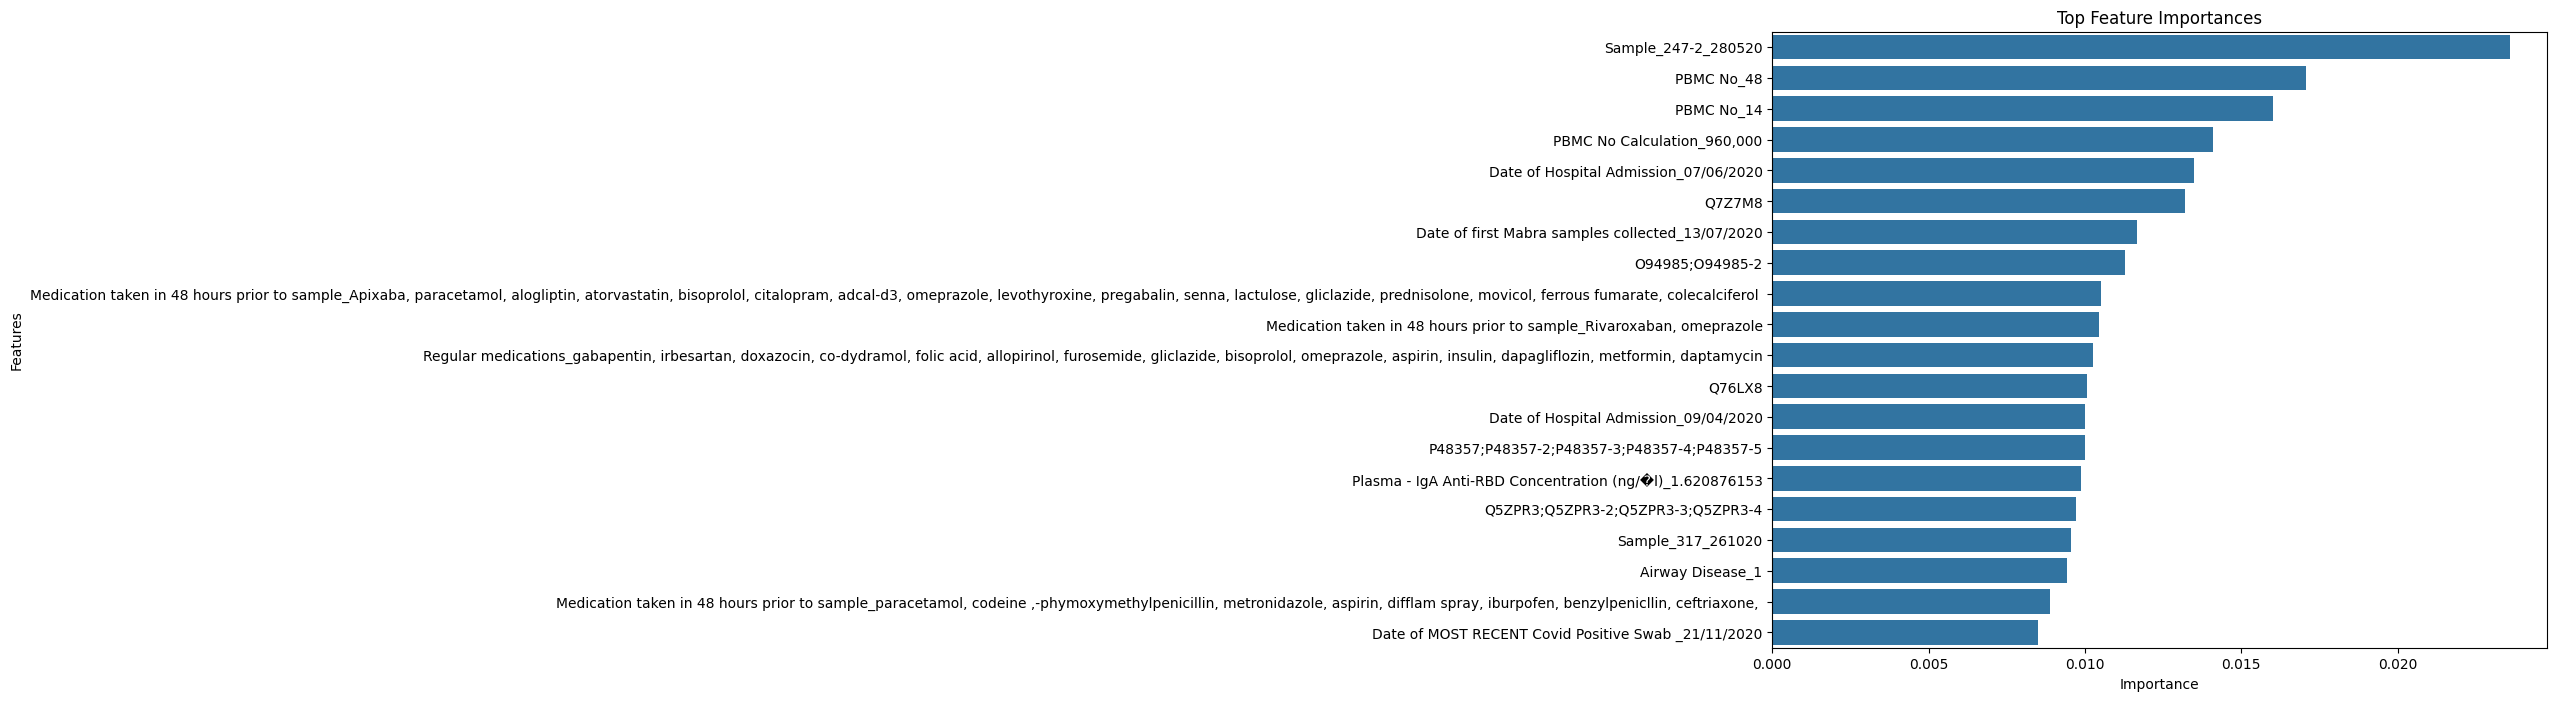

In [53]:
# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_features.importance, y=top_features.index)
plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()